# **Diagnóstico y mitigación de sesgo de género en embeddings de palabras**

### Grupo 2:
#### Sandra Monica Olariaga
#### Patricia Loto
#### Verónica Bornancini

## basado en el workshop https://learn.responsibly.ai/word-embedding

y sobre el toolkit [`responsibly`](https://docs.responsibly.ai/) - para auditar y mitigar sesgo y obtener equidad en los sistemas de aprendizaje automático.

A grandes rasgos, funciona así:

1. **Identify gender subspace**, is to identify a direction (or, more generally, a subspace) of the embedding that captures the bias. 

2. **Mitigate bias**: we define two options: Neutralize and
Equalize or Soften. 
  
  2.1. **Neutralize** ensures that gender neutral words are zero in the gender subspace.

  2.2. **Equalize** perfectly equalizes sets of words outside the subspace and thereby enforces the property that any neutral word is equidistant to all words in each equality set. For instance, if {grandmother, grandfather} and
{guy, gal} were two equality sets, then after equalization babysit would be equidistant to grandmother and grandfather and also equidistant to gal and guy, but presumably closer to the grandparents and further from the gal and guy. This is suitable for applications where one does not want any such pair to display any bias with respect to neutral words.

The disadvantage of Equalize is that it removes certain distinctions that are valuable in certain applications. For instance, one may wish a language model to assign a higher probability to the phrase to grandfather a
regulation) than to grandmother a regulation since grandfather has a meaning that grandmother does not –equalizing the two removes this distinction. The Soften algorithm reduces the differences between these sets.

Esto es una implementación de lo propuesto en: Bolukbasi Tolga, Kai-Wei Chang, James Y. Zou, Venkatesh Saligrama, and Adam T. Kalai. [Man is to computer programmer as woman is to homemaker? debiasing word embeddings](https://arxiv.org/abs/1607.06520). NIPS 2016.


# Descargos

En este ejemplo nos enfocamos en sesgo de género simplificándolo a un fenómeno binario, pero entendemos que se trata de una sobresimplificación, una primera aproximación a la familia de soluciones de mitigación que requiere de una mayor complejidad para tratar los fenómenos de sesgo como construcciones sociales.

Este material es un ejercicio puntual, no una perspectiva completa sobre sesgo en aprendizaje automático, equidad o inteligencia artificial responsable.

# 0. Configuración

## Instalar `responsibly`

In [ ]:
# !pip install --user responsibly

## Validar la instalación de `responsibly`

In [1]:
import responsibly

# deberían obtener '0.1.2'
responsibly.__version__

'0.1.2'

---

Si están trabajando en Colab, es normal que después de la instalación tengan el error **`ModuleNotFoundError: No module named 'responsibly'`**.
<br/> <br/>
Reinicien el Kernel/Runtime (usen el menú de arriba o el botón en la notebook), salteen la celda de instalación (`!pip install --user responsibly`) y ejecuten la celda previa de vuelta. 

# 1. Jugar con el embedding de Word2Vec

Con el paquete [`responsibly`](http://docs.responsibly.ai) viene la función [`responsibly.we.load_w2v_small`]() que devuelve un objeto [`KeyedVectors`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors) de [`gensim`](https://radimrehurek.com/gensim/). Este modelo fue entrenado con Google News - 100B tokens, vocabulario de 3 millones, vectores de 300 dimensiones, sólo nos quedamos con el vocabulario en minúscula.

Para más información: [Word2Vec](https://code.google.com/archive/p/word2vec/) - 

## 1.1. Propiedades Básicas

In [2]:
# ignorar warnings
# en general no queremos hacerlo pero ahora nos queremos enfocar en otra cosa

import warnings
warnings.filterwarnings('ignore')

In [3]:
from responsibly.we import load_w2v_small

w2v_small = load_w2v_small()

In [4]:
# tamanio del vocabulario

len(w2v_small.vocab)

26423

In [5]:
# obtener el vector de la palabra "home"

print('home =', w2v_small['home'])

home = [-0.00584168  0.0392657   0.00831084 -0.0443245   0.0426382   0.0119243
  0.0125867  -0.0934669   0.0698593   0.0416747   0.0838311  -0.123338
 -0.0263779  -0.0139718   0.0224031  -0.07275     0.00605246  0.0278233
  0.00963576  0.106475    0.0775679  -0.0785314   0.0436018  -0.052274
 -0.00201749 -0.0115027  -0.0243303   0.0402293   0.0187897   0.00087324
  0.027221    0.0184284  -0.0722682  -0.0187897  -0.027221    0.00560078
 -0.0387839  -0.0737135   0.0445654   0.0183079   0.0436018  -0.00731715
  0.0900943   0.047697   -0.027221    0.0804586   0.0195124   0.0809404
  0.0414338   0.0137912  -0.016983    0.146464    0.0693775   0.0486606
 -0.0910579  -0.130083   -0.0597417   0.0900943   0.0112618  -0.0209578
 -0.0101778   0.0407111  -0.00069257  0.0110811  -0.0375795   0.0133696
 -0.0232463   0.0278233  -0.00123458  0.0558874   0.063596   -0.047697
  0.0332434  -0.0402293  -0.0520331   0.0344478  -0.011322    0.0030714
  0.00909375 -0.0128878   0.0285459   0.0380612   0.00502

In [6]:
# la dimensión del embedding de la palabra, en este caso, es 300

len(w2v_small['home'])

300

In [7]:
# todas las palabras están normalizadas (=tienen una norma igual a uno como vectores)

from numpy.linalg import norm

norm(w2v_small['home'])

1.0

In [8]:
# asegurémonos que todos los vectores están normalizados

from numpy.testing import assert_almost_equal

length_vectors = norm(w2v_small.vectors, axis=1)

assert_almost_equal(actual=length_vectors,
                    desired=1,
                    decimal=5)

## 1.2. Medir la semejanza entre palabras

Usaremos el [coseno](https://es.wikipedia.org/wiki/Similitud_coseno) como medida de semejanza (o distancia) entre palabras.
- Mide el coseno del ángulo entre dos vectores.
- Rango entre 1 (vectores idénticos) y -1 (vectores opuestos).
- En Python, para vectores normalizados (arrays de Numpy), usar el operador `@`

In [9]:
w2v_small['cat'] @ w2v_small['cat']

1.0000006

In [10]:
w2v_small['cat'] @ w2v_small['cats']

0.8099383

In [11]:
w2v_small['cat'] @ w2v_small['dog']

0.7609462

In [12]:
w2v_small['cat'] @ w2v_small['cow']

0.40352482

In [13]:
w2v_small['cat'] @ w2v_small['graduated']

-0.003788825

## 1.3. Visualización del Word Embedding usando T-SNE 

<small>fuente: [Google's Seedbank](https://research.google.com/seedbank/seed/pretrained_word_embeddings)</small>

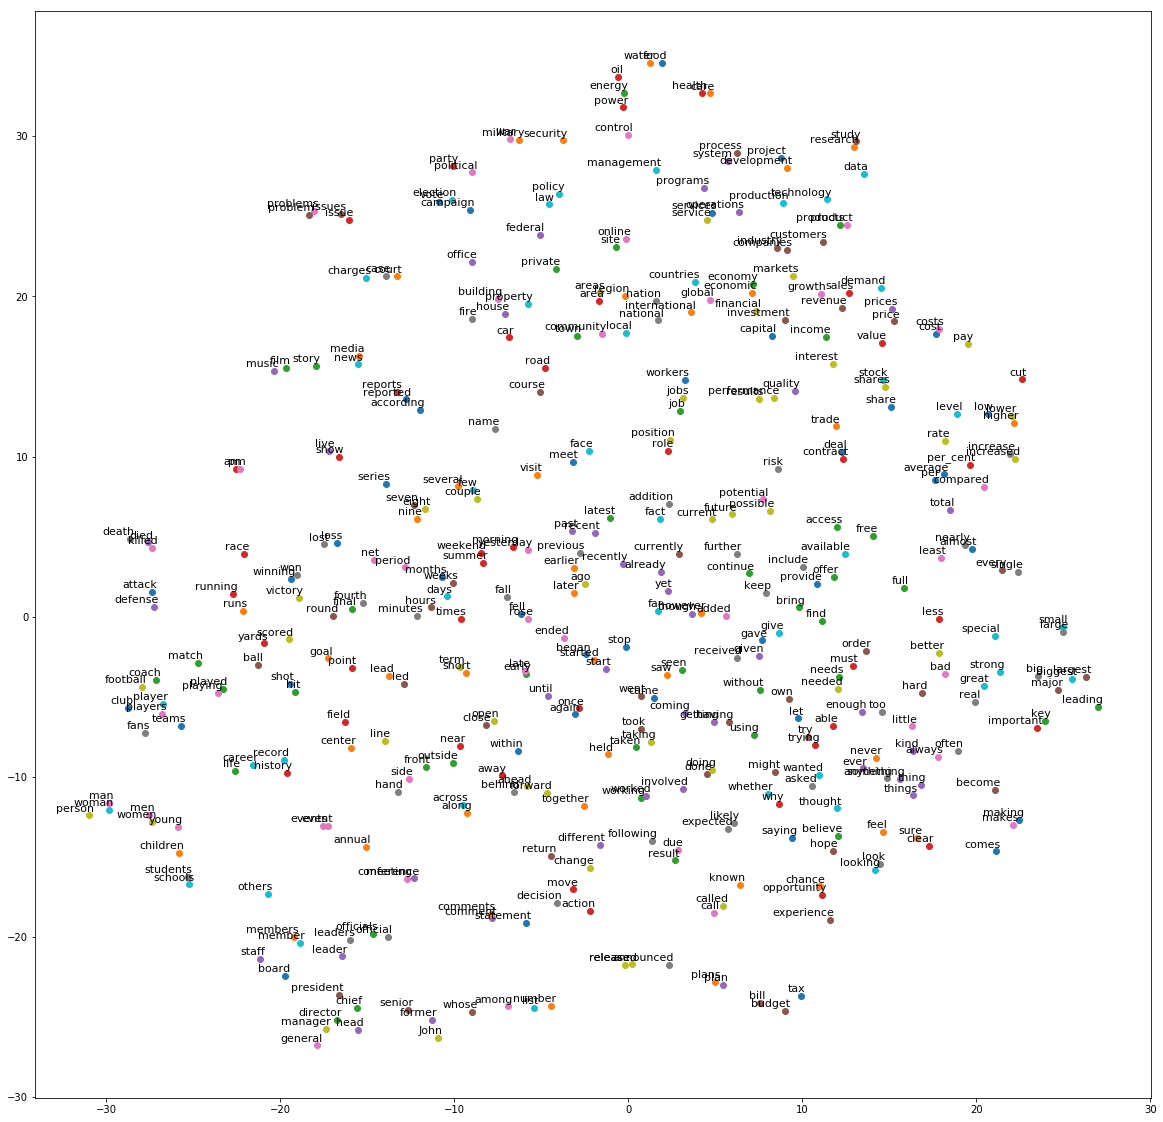

In [14]:
from sklearn.manifold import TSNE
from matplotlib import pylab as plt

# tomar las palabras más frecuentes del corpus entre 200 y 600
words = [word for word in w2v_small.index2word[200:600]]

# convertir las palabras a vectores
embeddings = [w2v_small[word] for word in words]

# hacer T-SNE
words_embedded = TSNE(n_components=2).fit_transform(embeddings)

# ... y visualizar!
plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom', size=11)
plt.show()

### Extra: [Tensorflow Embedding Projector](http://projector.tensorflow.org)

## 1.4. Palabras más semejantes

Cuáles son las palabras más semejantes a una determinada palabra?

In [15]:
w2v_small.most_similar('lousy')

[('crappy', 0.7421993017196655),
 ('mediocre', 0.6720577478408813),
 ('bad', 0.6647641658782959),
 ('horrid', 0.6454887390136719),
 ('abysmal', 0.634009838104248),
 ('awful', 0.6135217547416687),
 ('terrible', 0.6132175922393799),
 ('horrible', 0.606008768081665),
 ('subpar', 0.5998159646987915),
 ('dismal', 0.5983309149742126)]

### 1.4.1 EXTRA: Cuál es la palabra que desentona?

Dada una lista de palabras, cuál desentona? Es decir, cuál es la que está más lejos de la media de palabras.

In [16]:
w2v_small.doesnt_match('girl man woman housekeeper'.split())

'housekeeper'

## 1.5. Suma de palabras

![](https://github.com/ResponsiblyAI/word-embedding/blob/master/images/vector-addition.png?raw=1)

<small>fuente: [Wikipedia](https://commons.wikimedia.org/wiki/File:Vector_add_scale.svg)</small>

In [17]:
# nature + science = ?

w2v_small.most_similar(positive=['carbon', 'environment'])

[('carbon_emissions', 0.6362009048461914),
 ('climate', 0.6291007995605469),
 ('emissions', 0.5946062803268433),
 ('emission', 0.5673102736473083),
 ('greenhouse_gases', 0.5670002698898315),
 ('greenhouse_gas', 0.5664278268814087),
 ('carbon_dioxide', 0.554796576499939),
 ('climate_change', 0.5357500314712524),
 ('environments', 0.5127712488174438),
 ('ecosystems', 0.5111806392669678)]

## 1.6. Analogía de vectores

![](https://www.tensorflow.org/images/linear-relationships.png)
<small>fuente: [Documentación de Tensorflow](https://www.tensorflow.org/tutorials/representation/word2vec)</small>

In [18]:
# man:king :: woman:?
# king - man + woman = ?

w2v_small.most_similar(positive=['man', 'justice'],
                       negative=['woman'])

[('criminal_justice', 0.47420644760131836),
 ('judicial', 0.44037508964538574),
 ('fairness', 0.4353832006454468),
 ('injustice', 0.4342385232448578),
 ('righteousness', 0.41804516315460205),
 ('judiciary', 0.3979630172252655),
 ('murderers', 0.3882646858692169),
 ('peace', 0.3704982101917267),
 ('liberty', 0.3684263229370117),
 ('perpetrators', 0.36073264479637146)]

In [19]:
w2v_small.most_similar(positive=['big', 'smaller'],
                       negative=['small'])

[('bigger', 0.7836998105049133),
 ('larger', 0.5866795778274536),
 ('biggest', 0.5240509510040283),
 ('huge', 0.5084124207496643),
 ('sharper', 0.48242905735969543),
 ('heavier', 0.4784499406814575),
 ('tougher', 0.46322107315063477),
 ('better', 0.46317416429519653),
 ('major', 0.4562188386917114),
 ('quicker', 0.4514269232749939)]

## 1.7. La dirección de un embedding puede verse como una relación

# $\overrightarrow{she} - \overrightarrow{he}$
# $\overrightarrow{smaller} - \overrightarrow{small}$
# $\overrightarrow{Spain} - \overrightarrow{Madrid}$


# 2. Diagnosticamos sesgo de género en embeddings

Esto es una implementación de lo propuesto en: Bolukbasi Tolga, Kai-Wei Chang, James Y. Zou, Venkatesh Saligrama, and Adam T. Kalai. [Man is to computer programmer as woman is to homemaker? debiasing word embeddings](https://arxiv.org/abs/1607.06520). NIPS 2016.

¿Cómo afecta el sesgo de género en embeddings en el contexto de aplicaciones downstream?

![](https://github.com/ResponsiblyAI/word-embedding/blob/master/images/examples-gender-bias-nlp.png?raw=1)

<small>fuente: Sun, T., Gaut, A., Tang, S., Huang, Y., ElSherief, M., Zhao, J., ... & Wang, W. Y. (2019). [Mitigating Gender Bias in Natural Language Processing: Literature Review](https://arxiv.org/pdf/1906.08976.pdf). arXiv preprint arXiv:1906.08976.</small>


## 2.1. Probemos algunas propiedades con expresiones que sabemos que están fuertemente marcadas por el género



In [20]:
# she:sister :: he:?
# sister - she + he = ?

w2v_small.most_similar(positive=['brother', 'she'],
                       negative=['he'])

[('sister', 0.794605016708374),
 ('daughter', 0.7510344982147217),
 ('mother', 0.7232228517532349),
 ('husband', 0.7024514675140381),
 ('niece', 0.6873900294303894),
 ('aunt', 0.6613579988479614),
 ('sisters', 0.6565696001052856),
 ('twin_sister', 0.6352079510688782),
 ('son', 0.6321481466293335),
 ('siblings', 0.6316263675689697)]

```
queen-king
waitress-waiter
sister-brother
mother-father
ovarian_cancer-prostate_cancer
convent-monastery
```

In [21]:
w2v_small.most_similar(positive=['carpentry', 'she'],
                       negative=['he'])

[('sewing', 0.5989980697631836),
 ('quilting', 0.5158857107162476),
 ('welding', 0.4752843976020813),
 ('knitting', 0.46505996584892273),
 ('carpenter', 0.45099231600761414),
 ('embroidery', 0.4441932439804077),
 ('paralegal', 0.44281601905822754),
 ('graphic_design', 0.44082707166671753),
 ('pottery', 0.43960294127464294),
 ('ceramics', 0.4377267360687256)]

```
sewing-carpentry
nurse-doctor
blond-burly
giggle-chuckle
sassy-snappy
volleyball-football
register_nurse-physician
interior_designer-architect
feminism-conservatism
vocalist-guitarist
diva-superstar
cupcakes-pizzas
housewife-shopkeeper
softball-baseball
cosmetics-pharmaceuticals
petite-lanky
charming-affable
hairdresser-barber
```

Parece que el método de generar analogías no es la forma más adecuada de observar sesgo en los embeddings, por la paradoja del observador: introduce sesgo, fuerza la producción de estereotipos de género!

Nissim, M., van Noord, R., van der Goot, R. (2019). [Fair is Better than Sensational: Man is to Doctor as Woman is to Doctor](https://arxiv.org/abs/1905.09866).


## 2.2. Qué sí nos da la analogía? La dirección del género!

# $\overrightarrow{she} - \overrightarrow{he}$

In [22]:
gender_direction = w2v_small['she'] - w2v_small['he']

gender_direction /= norm(gender_direction)

In [23]:
gender_direction @ w2v_small['housing']

0.06385507

In [24]:
gender_direction @ w2v_small['architect']

-0.16785555

Con todos los recaudos de saber que estamos sobresimplificando el fenómeno, podemos ver que la palabra *architect* aparece en más contextos con *he* que con *she*, y viceversa para *interior designer*.

Basándonos en esta propiedad, podemos calcular la dirección del género usano varios pares de palabras que sabemos que están fuertemente marcadas para género.:

- woman - man
- girl - boy
- she - he
- mother - father
- daughter - son
- gal - guy
- female - male
- her - his
- herself - himself
- Mary - John

## 2.2. Prueben con algunas palabras
Reflexión: ¿están haciendo análisis exploratorio o evaluación sistemática?

In [25]:
gender_direction @ w2v_small['engineer']

-0.118621394

## 2.3. Proyecciones

In [26]:
from responsibly.we import GenderBiasWE

w2v_small_gender_bias = GenderBiasWE(w2v_small, only_lower=True)

In [27]:
w2v_small_gender_bias.positive_end, w2v_small_gender_bias.negative_end

('she', 'he')

In [28]:
# dirección del género
w2v_small_gender_bias.direction[:10]

array([-0.10056252, -0.09987912, -0.05384335,  0.00480521,  0.01521063,
       -0.01666582,  0.00932552, -0.00625998, -0.11320096,  0.03992424])

In [29]:
from responsibly.we.data import BOLUKBASI_DATA

neutral_profession_names = BOLUKBASI_DATA['gender']['neutral_profession_names']

In [30]:
neutral_profession_names[:20]

['accountant',
 'acquaintance',
 'actor',
 'adjunct_professor',
 'administrator',
 'adventurer',
 'advocate',
 'aide',
 'alderman',
 'alter_ego',
 'ambassador',
 'analyst',
 'anthropologist',
 'archaeologist',
 'archbishop',
 'architect',
 'artist',
 'artiste',
 'assassin',
 'assistant_professor']

Nota: `actor` está en la lista de nombres de profesión neutros, y no`actress` porque parece que el uso de la palabra ha cambiado con el tiempo y ahora es más neutro, en comparación por ejemplo con  waiter-waitress (ver [Wikipedia - The term Actress](https://en.wikipedia.org/wiki/Actor#The_term_actress))

In [31]:
len(neutral_profession_names)

303

In [32]:
# proyección en la dirección de género de los nombres de profesión neutros

w2v_small_gender_bias.project_on_direction(neutral_profession_names[0])

0.008421647916552765

Visualicemos las proyecciones de las profesiones (neutras y específicas) en la dirección del género.

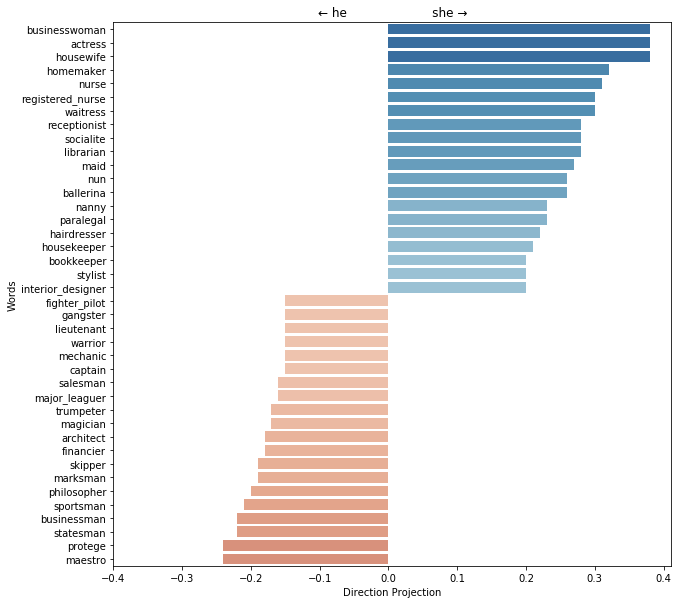

In [33]:
import matplotlib.pylab as plt

f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_bias.plot_projection_scores(n_extreme=20, ax=ax);

EXTRA: Demo - Visualizando sesgo de género con [Nubes de palabras](http://wordbias.umiacs.umd.edu/)

Las proyecciones en la dirección de género de las palabras de profesiones se corresponden con datos de ocupación desglosados por género, según se puede ver en el porcentaje de mujeres en diversas profesiones según la encuesta de población de 2017 del Labor Force Statistics: https://arxiv.org/abs/1804.06876

In [34]:
from operator import itemgetter  # 🛠️ For idiomatic sorting in Python

from responsibly.we.data import OCCUPATION_FEMALE_PRECENTAGE

sorted(OCCUPATION_FEMALE_PRECENTAGE.items(), key=itemgetter(1))

[('carpenter', 2),
 ('mechanician', 4),
 ('construction_worker', 4),
 ('laborer', 4),
 ('driver', 6),
 ('sheriff', 14),
 ('mover', 18),
 ('developer', 20),
 ('farmer', 22),
 ('guard', 22),
 ('chief', 27),
 ('janitor', 34),
 ('lawyer', 35),
 ('cook', 38),
 ('physician', 38),
 ('ceo', 39),
 ('analyst', 41),
 ('manager', 43),
 ('supervisor', 44),
 ('salesperson', 48),
 ('editor', 52),
 ('designers', 54),
 ('accountant', 61),
 ('auditor', 61),
 ('writer', 63),
 ('baker', 65),
 ('clerk', 72),
 ('cashier', 73),
 ('counselors', 73),
 ('attendant', 76),
 ('teacher', 78),
 ('sewer', 80),
 ('librarian', 84),
 ('assistant', 85),
 ('cleaner', 89),
 ('housekeeper', 89),
 ('nurse', 90),
 ('receptionist', 90),
 ('hairdressers', 92),
 ('secretary', 95)]

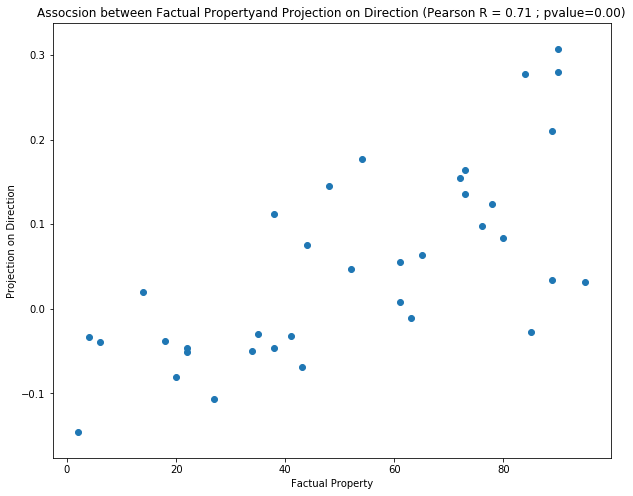

In [35]:
f, ax = plt.subplots(1, figsize=(10, 8))

w2v_small_gender_bias.plot_factual_association(ax=ax);

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). [Word embeddings quantify 100 years of gender and ethnic stereotypes](https://www.pnas.org/content/pnas/115/16/E3635.full.pdf). Proceedings of the National Academy of Sciences, 115(16), E3635-E3644.

![](https://github.com/ResponsiblyAI/word-embedding/blob/master/images/gender-bias-over-decades.png?raw=1)

<small>Data: Google Books/Corpus of Historical American English (COHA)</small>

## 2.4. Medición directa del sesgo

1. Proyectamos cada uno de los nombres de profesión neutros en la dirección de género
2. Calculamos el valor absoluto de cada proyección
3. Lo promediamos

In [36]:
# función de alto nivel en responsibly

w2v_small_gender_bias.calc_direct_bias()

0.07307905466893874

In [37]:
# qué hace responsibly internamente:

neutral_profession_projections = [w2v_small[word] @ w2v_small_gender_bias.direction
                                  for word in neutral_profession_names]

abs_neutral_profession_projections = [abs(proj) for proj in neutral_profession_projections]

sum(abs_neutral_profession_projections) / len(abs_neutral_profession_projections)

0.0730790545759565

**Atención** la medición directa de sesgo está haciendo asunciones fuertes sobre las palabras neutras.

## 2.5 Medición indirecta del sesgo
Semejanza por proyección en la misma "dirección de género".

In [38]:
w2v_small_gender_bias.generate_closest_words_indirect_bias('swimming',
                                                           'football')

projection  indirect_bias
end      word                                        
swimming swimmer              0.368331       0.004353
         lifeguard            0.305808       0.002589
         sailor               0.181589       0.007974
         instructor           0.129584       0.002956
         therapist            0.119868       0.073911
football coach               -0.214101       0.021178
         ballplayer          -0.215144       0.036385
         sportswriter        -0.220595       0.026358
         athletic_director   -0.231304      -0.017827
         footballer          -0.290781       0.015365

# 3. Mitigar sesgo

> We intentionally do not reference the resulting embeddings as "debiased" or free from all gender bias, and
prefer the term "mitigating bias" rather that "debiasing," to guard against the misconception that the resulting
embeddings are entirely "safe" and need not be critically evaluated for bias in downstream tasks. <small>James-Sorenson, H., & Alvarez-Melis, D. (2019). [Probabilistic Bias Mitigation in Word Embeddings](https://arxiv.org/pdf/1910.14497.pdf). arXiv preprint arXiv:1910.14497.</small>


## 3.1. Neutralizar

Si neutralizamos, vamos a eliminar la proyección de género de todas las palabras excepto las de género neutro, y después normalizamos.

**Atención** un prerequisito fuerte es tener la lista de palabras fuertemente marcadas para género.

In [39]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='neutralize', inplace=False)

In [40]:
print('home:',
      'antes =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'después = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: antes = 0.011340496779172276 después =  -1.1762454304428726e-09


In [41]:
print('man:',
      'antes =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'después = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: antes = -0.2209519293604172 después =  -0.2209519293604172


In [42]:
print('woman:',
      'antes =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'después = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: antes = 0.3403474745246815 después =  0.3403474745246814


In [43]:
w2v_small_gender_debias.calc_direct_bias()

1.1615064674639201e-09

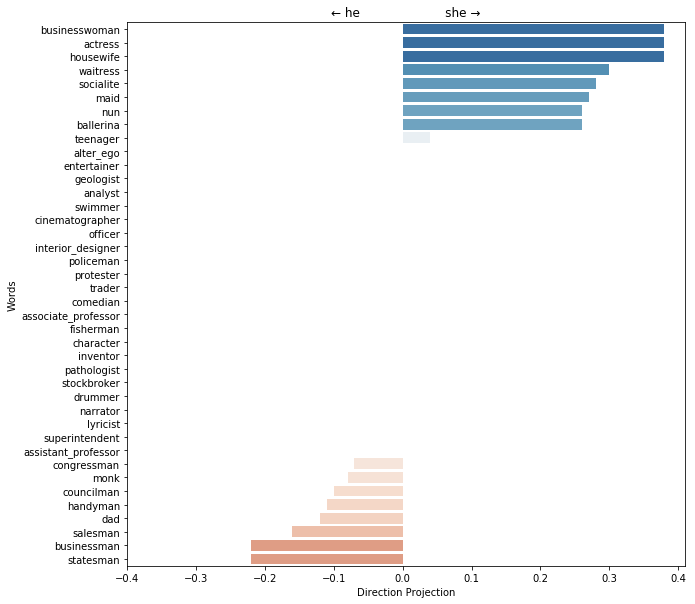

In [44]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

## 3.2. Ecualizar

Las palabras en la lista de palabras marcadas para género (como por ejemplo `man` y `woman`) pueden tener una proyección diferente en la dirección de género. Eso puede resultar en una similitud diferente a palabras neutras, como `kitchen`.

In [45]:
w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.model['kitchen']

0.10391626

In [46]:
w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.model['kitchen']

0.09767782

In [47]:
BOLUKBASI_DATA['gender']['equalize_pairs'][:10]

[['monastery', 'convent'],
 ['spokesman', 'spokeswoman'],
 ['Catholic_priest', 'nun'],
 ['Dad', 'Mom'],
 ['Men', 'Women'],
 ['councilman', 'councilwoman'],
 ['grandpa', 'grandma'],
 ['grandsons', 'granddaughters'],
 ['prostate_cancer', 'ovarian_cancer'],
 ['testosterone', 'estrogen']]

In [48]:
# BOLUKBASI_DATA

## 3.3. Eliminación de sesgo dura: Neutralizar y Ecualizar

In [49]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='hard', inplace=False)

In [50]:
print('home:',
      'before =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: before = 0.011340496779172276 after =  -1.1762454304428726e-09


In [51]:
print('man:',
      'before =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: before = -0.2209519293604172 after =  -0.34693385860531345


In [52]:
print('woman:',
      'before =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: before = 0.3403474745246815 after =  0.3469338613053841


In [53]:
w2v_small_gender_debias.calc_direct_bias()

1.1780665102619627e-09

In [54]:
w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.model['kitchen']

0.10079705

In [55]:
w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.model['kitchen']

0.10079705

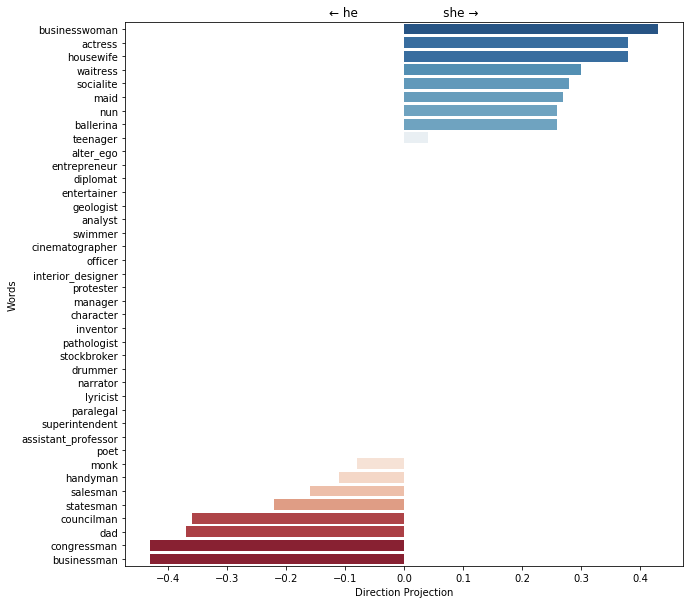

In [56]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

Después de mitigar el sesgo, el rendimiento del embedding resultante en benchmarks estándares no se ve fuertemente afectado.

In [57]:
w2v_small_gender_bias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  spearman_r  spearman_pvalue  \
 WS353          0.645           0.000       0.688            0.000   
 RG65           0.576           0.232       0.493            0.321   
 RW             0.611           0.000       0.655            0.000   
 Mturk          0.650           0.000       0.674            0.000   
 MEN            0.766           0.000       0.782            0.000   
 SimLex999      0.456           0.000       0.444            0.000   
 TR9856         0.666           0.000       0.676            0.000   
 
            ratio_unkonwn_words  
 WS353                    9.915  
 RG65                    14.286  
 RW                      77.384  
 Mturk                    1.558  
 MEN                     15.148  
 SimLex999                1.702  
 TR9856                  89.722  ,
             score
 MSR-syntax  0.750
 Google      0.729)

In [58]:
w2v_small_gender_debias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  spearman_r  spearman_pvalue  \
 WS353          0.643           0.000       0.685            0.000   
 RG65           0.574           0.234       0.493            0.321   
 RW             0.611           0.000       0.655            0.000   
 Mturk          0.651           0.000       0.675            0.000   
 MEN            0.766           0.000       0.782            0.000   
 SimLex999      0.459           0.000       0.447            0.000   
 TR9856         0.665           0.000       0.674            0.000   
 
            ratio_unkonwn_words  
 WS353                    9.915  
 RG65                    14.286  
 RW                      77.384  
 Mturk                    1.558  
 MEN                     15.148  
 SimLex999                1.702  
 TR9856                  89.722  ,
             score
 MSR-syntax  0.751
 Google      0.726)

# 4. Explorar otros tipos de sesgo en word embeddings

## 4.1. Sesgo racial

Usaremos la clase [`responsibly.we.BiasWordEmbedding`](http://docs.responsibly.ai/word-embedding-bias.html#ethically.we.bias.BiasWordEmbedding). `GenderBiasWE` es una subclase de `BiasWordEmbedding`.

In [59]:
from responsibly.we import BiasWordEmbedding

w2v_small_racial_bias = BiasWordEmbedding(w2v_small, only_lower=True, verbose=True)

Identificar la dirección racial usando el método `sum`

In [60]:
white_common_names = ['Emily', 'Anne', 'Jill', 'Allison', 'Laurie', 'Sarah', 'Meredith', 'Carrie',
                      'Kristen', 'Todd', 'Neil', 'Geoffrey', 'Brett', 'Brendan', 'Greg', 'Matthew',
                      'Jay', 'Brad']

black_common_names = ['Aisha', 'Keisha', 'Tamika', 'Lakisha', 'Tanisha', 'Latoya', 'Kenya', 'Latonya',
                      'Ebony', 'Rasheed', 'Tremayne', 'Kareem', 'Darnell', 'Tyrone', 'Hakim', 'Jamal',
                      'Leroy', 'Jermaine']

w2v_small_racial_bias._identify_direction('Whites', 'Blacks',
                                          definitional=(white_common_names, black_common_names),
                                          method='sum')

Identify direction using sum method...


Usar los nombres de profesiones neutros para medir el sesgo racial.

In [61]:
neutral_profession_names = w2v_small_racial_bias._filter_words_by_model(BOLUKBASI_DATA['gender']['neutral_profession_names'])

In [62]:
w2v_small_racial_bias.calc_direct_bias(neutral_profession_names)

0.057031346095274736

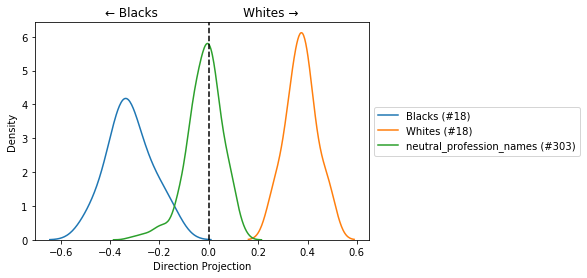

In [63]:
w2v_small_racial_bias.plot_dist_projections_on_direction({'neutral_profession_names': neutral_profession_names,
                                                 'Whites': white_common_names,
                                                 'Blacks': black_common_names});

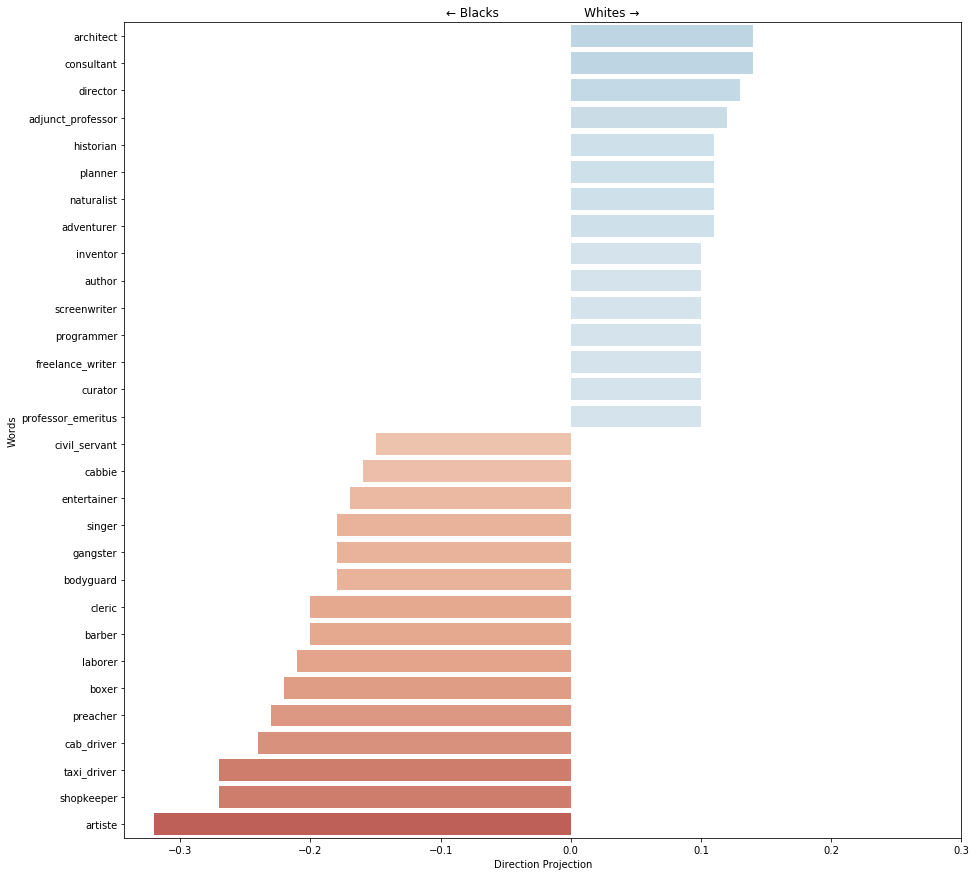

In [64]:
f, ax = plt.subplots(figsize=(15, 15))
w2v_small_racial_bias.plot_projection_scores(neutral_profession_names, 15, ax=ax);

Calcular la medida directa de sesgo

In [65]:
w2v_small_racial_bias.calc_direct_bias(neutral_words= neutral_profession_names)

0.057031346095274736

In [66]:
# w2v_small_racial_bias.calc_direct_bias()
neutral_racial_projections = [w2v_small[word] @ w2v_small_racial_bias.direction
                                  for word in neutral_profession_names]

abs_neutral_racial_projections = [abs(proj) for proj in neutral_racial_projections]

sum(abs_neutral_racial_projections) / len(abs_neutral_racial_projections)

0.057031341177147615

In [67]:
w2v_small_racial_bias.model['Leroy'] @ w2v_small_racial_bias.model['architect']

0.059917007

In [68]:
w2v_small_racial_bias.model['Leroy'] @ w2v_small_racial_bias.model['civil_servant']

0.032362252

In [69]:
w2v_small_racial_bias.model['Brad'] @ w2v_small_racial_bias.model['architect']

0.114469066

In [70]:
w2v_small_racial_bias.model['Brad'] @ w2v_small_racial_bias.model['civil_servant']

-0.12710309

Sigan explorando el sesgo racial

In [71]:
neutral_profession_names = w2v_small_racial_bias._filter_words_by_model(BOLUKBASI_DATA['gender']['neutral_profession_names'])
# neutral_profession_names = BOLUKBASI_DATA['gender']['neutral_profession_names']

In [72]:
w2v_small_racial_debias = w2v_small_racial_bias.debias(method = 'neutralize' , neutral_words= neutral_profession_names, inplace=False)

100%|█████████████████████████████████████| 303/303 [00:00<00:00, 33666.43it/s]

Neutralize...


**Podemos ver ahora el cambio en la distancia a las profesiones** 

In [73]:
w2v_small_racial_debias.model['Leroy'] @ w2v_small_racial_debias.model['architect']

0.081100054

In [74]:
w2v_small_racial_debias.model['Leroy'] @ w2v_small_racial_bias.model['civil_servant']

0.032362252

In [75]:
w2v_small_racial_debias.model['Brad'] @ w2v_small_racial_debias.model['architect']

0.05158242

In [76]:
w2v_small_racial_debias.model['Brad'] @ w2v_small_racial_debias.model['civil_servant']

-0.061711207

In [77]:
# Hacenos el calculo para el debias 
# w2v_small_racial_bias.calc_direct_bias()
neutral_racial_projections = [w2v_small[word] @ w2v_small_racial_debias.direction
                                  for word in neutral_profession_names]

abs_neutral_racial_projections = [abs(proj) for proj in neutral_racial_projections]

sum(abs_neutral_racial_projections) / len(abs_neutral_racial_projections)

0.057031341303168163

In [78]:
w2v_small_racial_bias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  spearman_r  spearman_pvalue  \
 WS353          0.645           0.000       0.688            0.000   
 RG65           0.576           0.232       0.493            0.321   
 RW             0.611           0.000       0.655            0.000   
 Mturk          0.650           0.000       0.674            0.000   
 MEN            0.766           0.000       0.782            0.000   
 SimLex999      0.456           0.000       0.444            0.000   
 TR9856         0.666           0.000       0.676            0.000   
 
            ratio_unkonwn_words  
 WS353                    9.915  
 RG65                    14.286  
 RW                      77.384  
 Mturk                    1.558  
 MEN                     15.148  
 SimLex999                1.702  
 TR9856                  89.722  ,
             score
 MSR-syntax  0.750
 Google      0.729)

In [79]:
w2v_small_racial_debias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  spearman_r  spearman_pvalue  \
 WS353          0.645           0.000       0.688            0.000   
 RG65           0.576           0.232       0.493            0.321   
 RW             0.611           0.000       0.655            0.000   
 Mturk          0.650           0.000       0.674            0.000   
 MEN            0.767           0.000       0.782            0.000   
 SimLex999      0.456           0.000       0.444            0.000   
 TR9856         0.666           0.000       0.675            0.000   
 
            ratio_unkonwn_words  
 WS353                    9.915  
 RG65                    14.286  
 RW                      77.384  
 Mturk                    1.558  
 MEN                     15.148  
 SimLex999                1.702  
 TR9856                  89.722  ,
             score
 MSR-syntax  0.750
 Google      0.729)

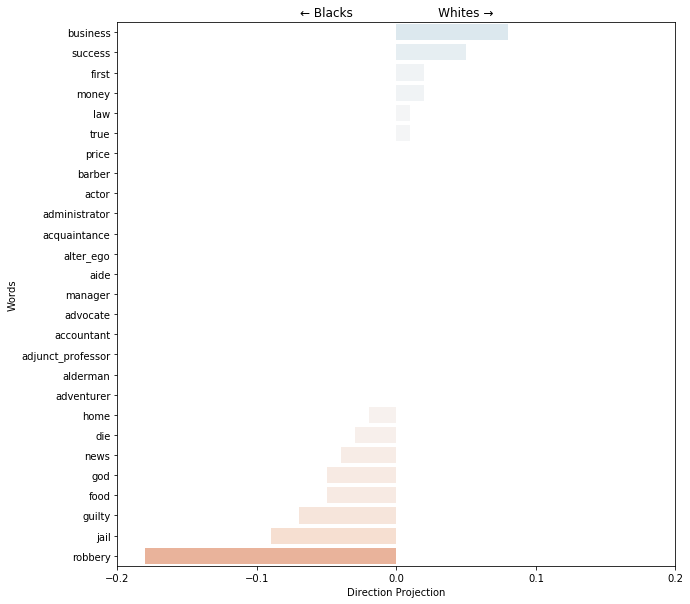

In [81]:
f, ax = plt.subplots(1, figsize=(10, 10))
w2v_small_racial_debias.plot_projection_scores(['robbery','manager', 
                                                'home', 'jail', 'guilty',
                                                'food', 'barber', 'price', 'law', 'first', 'true', 'god', 'die',
                                                'home', 'news', 'success','money', 'business',
                                                'accountant', 'acquaintance', 'actor', 'adjunct_professor', 
                                                'administrator', 'adventurer', 'advocate', 'aide', 'alderman',
                                                'alter_ego'], n_extreme=40, ax=ax);

# Recursos

## [Doing Data Science Responsibly - Resources](https://handbook.responsibly.ai/appendices/resources.html)

In particular:

- CVPR 2020 - [FATE Tutorial](https://youtu.be/-xGvcDzvi7Q) [Video]

- fast.ai - [Algorithmic Bias (NLP video 16)](https://youtu.be/pThqge9QDn8) [Video]

-  Solon Barocas, Moritz Hardt, Arvind Narayanan - [Fairness and machine learning - Limitations and Opportunities](https://fairmlbook.org/) [Textbook]



## Non-Technical Overview with More Downstream Application Examples
- [Google - Text Embedding Models Contain Bias. Here's Why That Matters.](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html)
- [Kai-Wei Chang (UCLA) - What It Takes to Control Societal Bias in Natural Language Processing](https://www.youtube.com/watch?v=RgcXD_1Cu18)
- Sun, T., Gaut, A., Tang, S., Huang, Y., ElSherief, M., Zhao, J., ... & Wang, W. Y. (2019). [Mitigating Gender Bias in Natural Language Processing: Literature Review](https://arxiv.org/pdf/1906.08976.pdf). arXiv preprint arXiv:1906.08976.

## Additional Related Work

- **Understanding Bias**
    - Ethayarajh, K., Duvenaud, D., & Hirst, G. (2019, July). [Understanding Undesirable Word Embedding Associations](https://arxiv.org/pdf/1908.06361.pdf). In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (pp. 1696-1705). - **Including critical analysis of the current metrics and debiasing methods (quite technical)**

  - Brunet, M. E., Alkalay-Houlihan, C., Anderson, A., & Zemel, R. (2019, May). [Understanding the Origins of Bias in Word Embeddings](https://arxiv.org/pdf/1810.03611.pdf). In International Conference on Machine Learning (pp. 803-811).


- **Discovering Biases**
  - Swinger, N., De-Arteaga, M., Heffernan IV, N. T., Leiserson, M. D., & Kalai, A. T. (2019, January). [What are the biases in my word embedding?](https://arxiv.org/pdf/1812.08769.pdf). In Proceedings of the 2019 AAAI/ACM Conference on AI, Ethics, and Society (pp. 305-311). ACM.
    Measuring Gender Bias in Word Embeddings across Domains and Discovering New Gender Bias Word Categories
  
  - Chaloner, K., & Maldonado, A. (2019, August). [Measuring Gender Bias in Word Embeddings across Domains and Discovering New Gender Bias Word Categories](https://www.aclweb.org/anthology/W19-3804). In Proceedings of the First Workshop on Gender Bias in Natural Language Processing (pp. 25-32).


- **Fairness in Classification**
  - Prost, F., Thain, N., & Bolukbasi, T. (2019, August). [Debiasing Embeddings for Reduced Gender Bias in Text Classification](https://arxiv.org/pdf/1908.02810.pdf). In Proceedings of the First Workshop on Gender Bias in Natural Language Processing (pp. 69-75).
  
  - Romanov, A., De-Arteaga, M., Wallach, H., Chayes, J., Borgs, C., Chouldechova, A., ... & Kalai, A. (2019, June). [What's in a Name? Reducing Bias in Bios without Access to Protected Attributes](https://arxiv.org/pdf/1904.05233.pdf). In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 4187-4195).


- **Other**
  
  - Zhao, J., Wang, T., Yatskar, M., Cotterell, R., Ordonez, V., & Chang, K. W. (2019, June). [Gender Bias in Contextualized Word Embeddings](https://arxiv.org/pdf/1904.03310.pdf). In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 629-634). [slides](https://jyzhao.net/files/naacl19.pdf)

  - Zhou, P., Shi, W., Zhao, J., Huang, K. H., Chen, M., & Chang, K. W. [Analyzing and Mitigating Gender Bias in Languages with Grammatical Gender and Bilingual Word Embeddings](https://aiforsocialgood.github.io/icml2019/accepted/track1/pdfs/47_aisg_icml2019.pdf). ICML 2019 - AI for Social Good. [Poster](https://aiforsocialgood.github.io/icml2019/accepted/track1/posters/47_aisg_icml2019.pdf)

- Zhao, J., Mukherjee, S., Hosseini, S., Chang, K. W., & Awadallah, A. [Gender Bias in Multilingual Embeddings](https://www.researchgate.net/profile/Subhabrata_Mukherjee/publication/340660062_Gender_Bias_in_Multilingual_Embeddings/links/5e97428692851c2f52a6200a/Gender-Bias-in-Multilingual-Embeddings.pdf).


##### Complete example of using `responsibly` with Word2Vec, GloVe and fastText: http://docs.responsibly.ai/notebooks/demo-gender-bias-words-embedding.html


## Bias in NLP

Around dozen of papers on this field until 2019, but nowdays plenty of work is done. Two venues from back then:
- [1st ACL Workshop on Gender Bias for Natural Language Processing](https://genderbiasnlp.talp.cat/)
- [NAACL 2019](https://naacl2019.org/)
